In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from pandas import set_option
from matplotlib import pyplot
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

np.random.seed(7)

## Data visualization

We will work with the dataset imported from https://www.kaggle.com/datasets/hojjatk/mnist-dataset/data. In the same page there are a few snippets of code to load the dataset, which we import in the following:

In [2]:
import struct
from array import array
from os.path import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

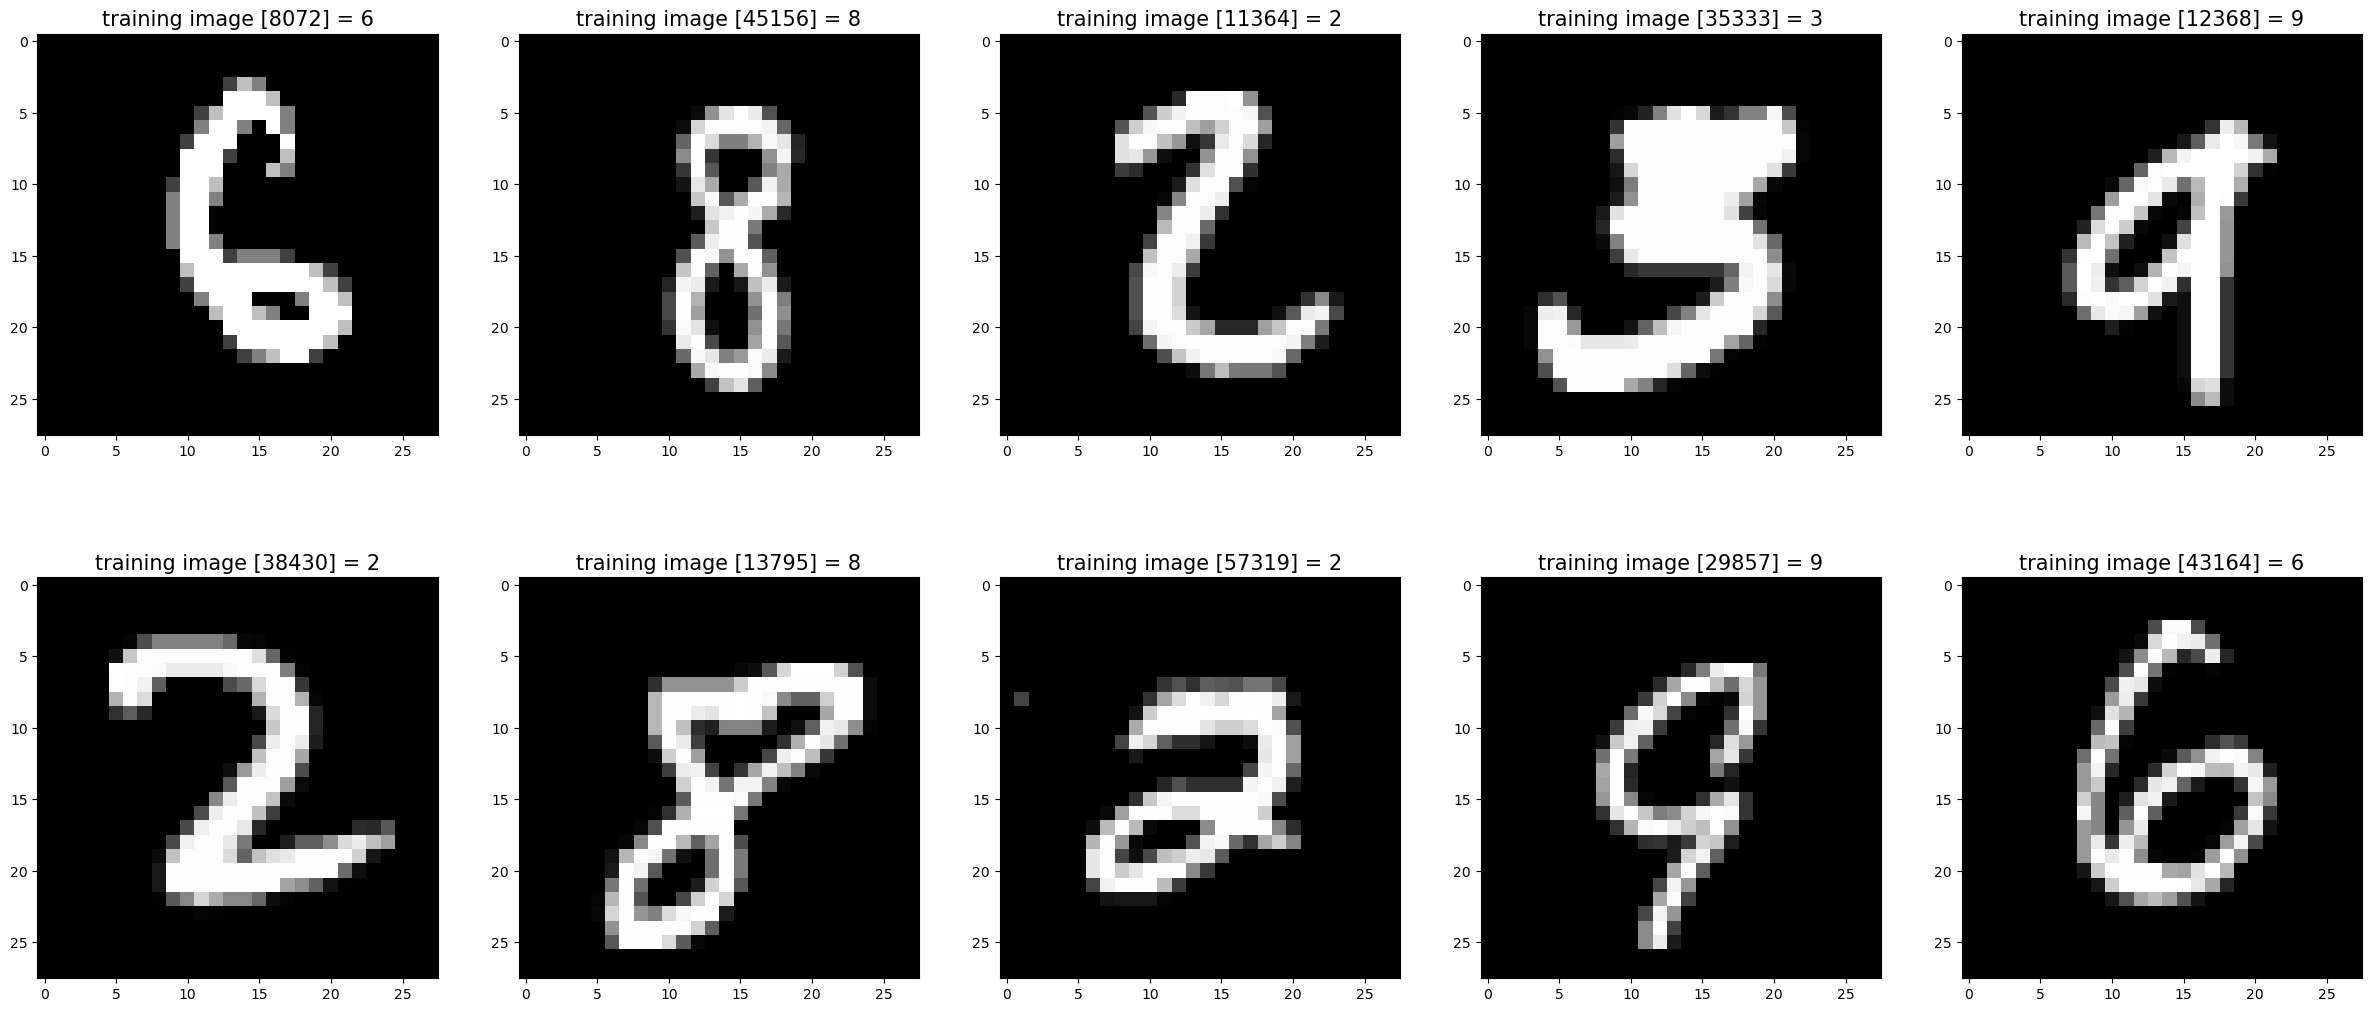

In [3]:
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '/MNIST/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    
  

show_images(images_2_show, titles_2_show)

In [4]:
X_train = np.array(x_train)
Y_train = np.array(y_train)
print(X_train.shape)
print(Y_train.shape)

(60000, 28, 28)
(60000,)


In [5]:
Y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [6]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [7]:
L = len(X_train[0])
N_train = len(X_train)
print(L, N_train)

28 60000


So each sample $i$ is a matrix $X^{(i)}$ of 28 by 28 8-bit integers, each entry representing a scale of grey from 0 (black) to 255 (white). From this we can derive an array of 784 features $x^{(i)}$ by reshaping. Each target $y^{(i)}$ is an integer from 0 to 9.

In [8]:
rX_train = np.reshape(X_train, (N_train, L**2))

In [9]:
rX_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

and we can check how many samples per class we have:

In [61]:
Counter(Y_train)

Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

where we see that the classes are balanced.

## Preprocess data

We can shift and rescale the data in X_train so that each point lies in the interval [-1, 1]. This will help in the convergence of the variational methods we will use to minimize the cost function. Since all data lies between 0 and 255 we can use MinMaxScaler without worrying about outliers.

In [10]:
# Define scaler and fit it onto training data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(rX_train)

# scale training set
rX_train = scaler.transform(rX_train)

In [11]:
rX_train[0][150:170]

array([-1.        , -1.        , -0.97647059, -0.85882353, -0.85882353,
       -0.85882353, -0.01176471,  0.06666667,  0.37254902, -0.79607843,
        0.30196078,  1.        ,  0.9372549 , -0.00392157, -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ])

## Model choice and evaluation

We split the current train dataset into two parts: a proper training dataset X_t to train the models and a cross-validation dataset X_cv to help us in choosing the best regularization parameters and diagnose underfitting/overfitting problems.

In [12]:
test_size = 1.0/3 # will give us 40.000 samples for training and 20.000 for cross-validation
seed = 7 # to reproduce results
X_t, X_cv, Y_t, Y_cv = train_test_split(rX_train, Y_train, test_size=test_size, random_state=seed)

There are multiple ways to approach multiclass classification problems. Here, we are going to focus on a one-vs-rest model and a multinomial model.

## One-Vs-Rest

For the one-vs-rest approach, it is convenient to prepare additional target vectors $y_n$ = `Yn` where the single-digit number $n$ is set to 1 and all the others are set to 0. We define a function for that:

In [13]:
# We define a function that takes as input a target vector Y and returns a list of 10 vectors Yn, 
# such that Yn[n] has all the digits == n set to 1 and all the other set to 0
def multi_to_OH(Y):
    Yn = [(Y == n).astype(int) for n in range(10)]
    return Yn

In [14]:
Yn_t = multi_to_OH(Y_t)
Yn_t

[array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 1]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 1, 1, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 1, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 1, ..., 0, 0, 0])]

And we can also check the skewness of each class:

In [15]:
from scipy.stats import skew
print([skew(data) for data in Yn_t])

[2.6754909273865586, 2.471834355123664, 2.655140570858025, 2.647813806028431, 2.7252916409935173, 2.8781694447614683, 2.6871877869326433, 2.584434765824827, 2.712793373263559, 2.6629678931096628]


We can now fit a Logistic Regression over each class using sklearn's `OneVsRestClassifier`, which allows us to compute the various optimizations in parallel:

In [16]:
ovr_model = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=10000), n_jobs = -1)
ovr_model.fit(X_t, Y_t)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=10000), n_jobs=-1)

and test each model's score on both the training and the cross-validation dataset:

In [17]:
acc_train = ovr_model.score(X_t, Y_t)
acc_cv = ovr_model.score(X_cv, Y_cv)
print("Accuracy on training set: %.3f%%" % (acc_train*100.0))
print("Accuracy on cross-validation set: %.3f%%" % (acc_cv*100.0))

Accuracy on training set: 93.430%
Accuracy on cross-validation set: 91.300%


We see that our model scores a 91.3% accuracy on the cross-validation dataset, before any kind of tweaking or optimization.
But now that we have our measure of accuracy we can run some diagnosis, for example by plotting the learning curves of our model:

In [18]:
# Check wheter there's underfitting or overfitting by plotting learning curves
# i.e. training and cv errors as functions of the number of samples m
# error J is defined as 1-accuracy

J_train = []
J_cv = []
mvals = list(range(20, 20050, 1000)) # set number of samples
for m in mvals:
    temp_model = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=10000), n_jobs=-1)
    # fit temp model to first m samples
    temp_model.fit(X_t[:m], Y_t[:m])
    
    # compute and save error on train set
    acc_train = temp_model.score(X_t[:m], Y_t[:m])
    J_train.append(1-acc_train)
    print("Accuracy on training set: %.3f%%" % (acc_train*100.0))
    
    # compute and save error on cv set
    acc_cv = temp_model.score(X_cv[:m], Y_cv[:m])
    J_cv.append(1-acc_cv)
    print("Accuracy on cross-validation set: %.3f%%" % (acc_cv*100.0))

Accuracy on training set: 100.000%
Accuracy on cross-validation set: 45.000%
Accuracy on training set: 100.000%
Accuracy on cross-validation set: 83.235%
Accuracy on training set: 99.802%
Accuracy on cross-validation set: 86.089%
Accuracy on training set: 99.404%
Accuracy on cross-validation set: 87.053%
Accuracy on training set: 98.905%
Accuracy on cross-validation set: 87.488%
Accuracy on training set: 98.207%
Accuracy on cross-validation set: 87.729%
Accuracy on training set: 97.375%
Accuracy on cross-validation set: 87.741%
Accuracy on training set: 96.823%
Accuracy on cross-validation set: 88.447%
Accuracy on training set: 96.559%
Accuracy on cross-validation set: 89.040%
Accuracy on training set: 96.364%
Accuracy on cross-validation set: 89.424%
Accuracy on training set: 95.938%
Accuracy on cross-validation set: 89.461%
Accuracy on training set: 95.635%
Accuracy on cross-validation set: 89.574%
Accuracy on training set: 95.383%
Accuracy on cross-validation set: 89.700%
Accuracy o

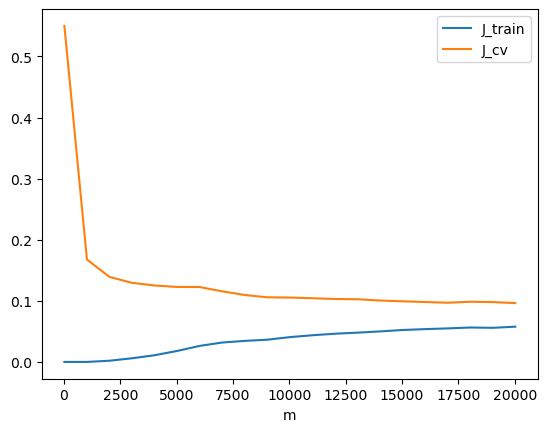

In [19]:
fig, ax = plt.subplots(1,1)
ax.plot(mvals, J_train, label="J_train")
ax.plot(mvals, J_cv, label="J_cv")
ax.set_xlabel("m")
ax.legend()

It seems our model suffers from some overfitting, due to the gap between the test curve and the cross-validation curve in the limit of large $m$. We can improve this by increasing the regularization parameter, i.e. decreasing the `C` parameter in `LogisticRegression`.
We thus repeatedly train the model by performing a sweep over decreasing values of `C`; the best value of `C` will be the one that minimizes the cross-validation error.

In [20]:
C_list = [10**i for i in range(-4, 1)]    # sweep over different orders of magnitude 

reg_models = [OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=10000, C=C), n_jobs=-1) for C in C_list]
J_cv_C = []
for j in range(len(C_list)):
    print(f"Training model with C = {C_list[j]}")
    reg_models[j].fit(X_t, Y_t)
    J_cv_C.append(1-reg_models[j].score(X_cv, Y_cv))
    
posmin = np.argmin(J_cv_C)
C_best = C_list[posmin]
ovr_model_bestC = reg_models[posmin]

Training model with C = 0.0001
Training model with C = 0.001
Training model with C = 0.01
Training model with C = 0.1
Training model with C = 1


In [21]:
C_best

0.1

In [22]:
acc_train = ovr_model_bestC.score(X_t, Y_t)
acc_cv = ovr_model_bestC.score(X_cv, Y_cv)
print("Accuracy on training set: %.3f%%" % (acc_train*100.0))
print("Accuracy on cross-validation set: %.3f%%" % (acc_cv*100.0))

Accuracy on training set: 92.877%
Accuracy on cross-validation set: 91.380%


We see that increasing the regularization parameter led to a small increase in the accuracy on the cross-validation dataset, as well as a small reduction of the gap between the learning curves at large $m$. Another thing we could try is removing some of the features. For example, we could crop the pictures in the dataset, reducing them to 22 by 22 pixels images:

In [23]:
X_t.shape

(40000, 784)

In [24]:
X_lf_t = np.reshape(X_t, (40000, 28, 28))
X_lf_t = np.reshape(X_lf_t[:,3:25,3:25], (40000, 22**2))

In [25]:
X_lf_t.shape

(40000, 484)

Which reduces the number of features for each sample. Let's try it out:

In [26]:
ovr_lf_model = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=10000), n_jobs = -1)
ovr_lf_model.fit(X_lf_t, Y_t)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=10000), n_jobs=-1)

In [27]:
X_lf_cv = np.reshape(X_cv, (20000, 28, 28))
X_lf_cv = np.reshape(X_lf_cv[:,3:25,3:25], (20000, 22**2))

In [28]:
acc_train = ovr_lf_model.score(X_lf_t, Y_t)
acc_cv = ovr_lf_model.score(X_lf_cv, Y_cv)
print("Accuracy on training set: %.3f%%" % (acc_train*100.0))
print("Accuracy on cross-validation set: %.3f%%" % (acc_cv*100.0))

Accuracy on training set: 93.088%
Accuracy on cross-validation set: 91.095%


However, it seems it's making the problem worse.

Let's try a different approach and change the training-to-cross-validation ratio, so that the model has less samples to train on (and thus there's less overfitting):

In [29]:
test_size = 0.4 # 60-40 split
seed = 7
X_t2, X_cv2, Y_t2, Y_cv2 = train_test_split(rX_train, Y_train, test_size=test_size, random_state=seed)

In [30]:
ovr_model2 = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=10000, C=0.1), n_jobs = -1)
ovr_model2.fit(X_t2, Y_t2)

OneVsRestClassifier(estimator=LogisticRegression(C=0.1, max_iter=10000),
                    n_jobs=-1)

In [31]:
acc_train = ovr_model2.score(X_t2, Y_t2)
acc_cv = ovr_model2.score(X_cv2, Y_cv2)
print("Accuracy on training set: %.3f%%" % (acc_train*100.0))
print("Accuracy on cross-validation set: %.3f%%" % (acc_cv*100.0))

Accuracy on training set: 92.864%
Accuracy on cross-validation set: 91.388%


This leads to a small increase in the accuracy on the cross-validation dataset. Let's try changing the ratio once more:

In [32]:
test_size = 0.5 # 40-60 split
seed = 7
X_t3, X_cv3, Y_t3, Y_cv3 = train_test_split(rX_train, Y_train, test_size=test_size, random_state=seed)

In [33]:
ovr_model3 = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=10000, C=0.1), n_jobs = -1)
ovr_model3.fit(X_t3, Y_t3)
acc_train = ovr_model3.score(X_t3, Y_t3)
acc_cv = ovr_model3.score(X_cv3, Y_cv3)
print("Accuracy on training set: %.3f%%" % (acc_train*100.0))
print("Accuracy on cross-validation set: %.3f%%" % (acc_cv*100.0))

Accuracy on training set: 93.043%
Accuracy on cross-validation set: 91.290%


It seems the accuracy decreased once again. We thus stick with the previous split, and plot the learning curves again:

In [34]:
J_train2 = []
J_cv2 = []
mvals = list(range(20, 36050, 2000)) # set number of samples
for m in mvals:
    temp_model = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=10000, C=0.1), n_jobs=-1)
    # fit temp model to first m samples
    temp_model.fit(X_t2[:m], Y_t2[:m])
    
    # compute and save error on train set
    acc_train = temp_model.score(X_t2[:m], Y_t2[:m])
    J_train2.append(1-acc_train)
    print("Accuracy on training set: %.3f%%" % (acc_train*100.0))
    
    # compute and save error on cv set
    acc_cv = temp_model.score(X_cv2[:m], Y_cv2[:m])
    J_cv2.append(1-acc_cv)
    print("Accuracy on cross-validation set: %.3f%%" % (acc_cv*100.0))

Accuracy on training set: 100.000%
Accuracy on cross-validation set: 55.000%
Accuracy on training set: 97.129%
Accuracy on cross-validation set: 87.178%
Accuracy on training set: 95.299%
Accuracy on cross-validation set: 89.055%
Accuracy on training set: 94.585%
Accuracy on cross-validation set: 89.734%
Accuracy on training set: 94.002%
Accuracy on cross-validation set: 89.963%
Accuracy on training set: 93.792%
Accuracy on cross-validation set: 90.000%
Accuracy on training set: 93.436%
Accuracy on cross-validation set: 90.208%
Accuracy on training set: 93.424%
Accuracy on cross-validation set: 90.421%
Accuracy on training set: 93.302%
Accuracy on cross-validation set: 90.712%
Accuracy on training set: 93.097%
Accuracy on cross-validation set: 90.821%
Accuracy on training set: 93.017%
Accuracy on cross-validation set: 90.944%
Accuracy on training set: 92.970%
Accuracy on cross-validation set: 91.013%
Accuracy on training set: 93.027%
Accuracy on cross-validation set: 91.154%
Accuracy on

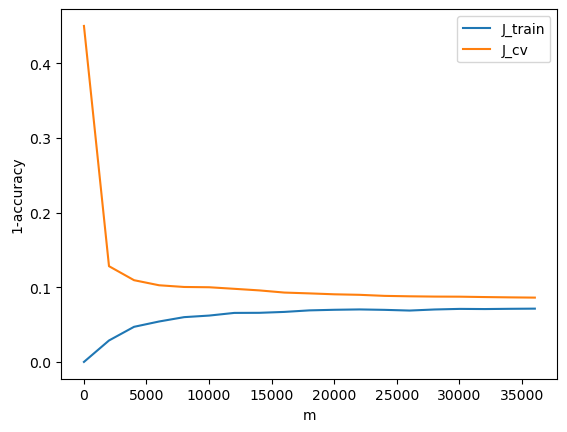

In [35]:
fig, ax = plt.subplots(1,1)
ax.plot(mvals, J_train2, label="J_train")
ax.plot(mvals, J_cv2, label="J_cv")
ax.set_xlabel("m")
ax.set_ylabel("1-accuracy")
ax.legend()

Which shows we managed to reduce overfitting in `ovr_model2`.

## Multinomial

We can repeat all the previous steps for the Multinomial Logistic Regression approach. We start immediatly with the optimal split we found for the OvR model, since we want to compare them on the same datasets.

In [36]:
multmodel = LogisticRegression(solver='lbfgs', max_iter=10000)
multmodel.fit(X_t2, Y_t2)

LogisticRegression(max_iter=10000)

In [37]:
acc_train = multmodel.score(X_t2, Y_t2)
acc_cv = multmodel.score(X_cv2, Y_cv2)
print("Accuracy on training set: %.3f%%" % (acc_train*100.0))
print("Accuracy on cross-validation set: %.3f%%" % (acc_cv*100.0))

Accuracy on training set: 94.781%
Accuracy on cross-validation set: 91.379%


In [38]:
# Check wheter there's underfitting or overfitting by plotting learning curves
# i.e. training and cv errors as functions of the number of samples m
# error J is defined as 1-accuracy

Jmult_train = []
Jmult_cv = []
mvals = list(range(20, 36050, 2000)) # set number of samples
for m in mvals:
    temp_model = LogisticRegression(solver='lbfgs', max_iter=10000)
    # fit temp model to first m samples
    temp_model.fit(X_t2[:m], Y_t2[:m])
    
    # compute and save error on train set
    acc_train = temp_model.score(X_t2[:m], Y_t2[:m])
    Jmult_train.append(1-acc_train)
    print("Accuracy on training set: %.3f%%" % (acc_train*100.0))
    
    # compute and save error on cv set
    acc_cv = temp_model.score(X_cv2[:m], Y_cv2[:m])
    Jmult_cv.append(1-acc_cv)
    print("Accuracy on cross-validation set: %.3f%%" % (acc_cv*100.0))

Accuracy on training set: 100.000%
Accuracy on cross-validation set: 55.000%
Accuracy on training set: 100.000%
Accuracy on cross-validation set: 86.436%
Accuracy on training set: 100.000%
Accuracy on cross-validation set: 87.886%
Accuracy on training set: 99.884%
Accuracy on cross-validation set: 88.605%
Accuracy on training set: 99.214%
Accuracy on cross-validation set: 88.691%
Accuracy on training set: 98.703%
Accuracy on cross-validation set: 88.862%
Accuracy on training set: 98.028%
Accuracy on cross-validation set: 89.143%
Accuracy on training set: 97.454%
Accuracy on cross-validation set: 89.230%
Accuracy on training set: 96.979%
Accuracy on cross-validation set: 89.950%
Accuracy on training set: 96.437%
Accuracy on cross-validation set: 89.983%
Accuracy on training set: 96.194%
Accuracy on cross-validation set: 90.255%
Accuracy on training set: 95.926%
Accuracy on cross-validation set: 90.427%
Accuracy on training set: 95.712%
Accuracy on cross-validation set: 90.546%
Accuracy 

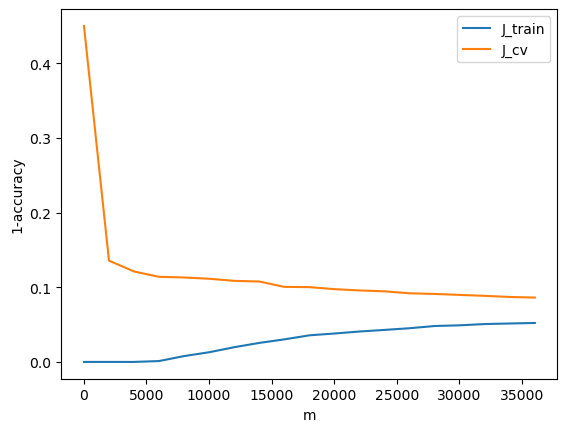

In [39]:
fig, ax = plt.subplots(1,1)
ax.plot(mvals, Jmult_train, label="J_train")
ax.plot(mvals, Jmult_cv, label="J_cv")
ax.set_xlabel("m")
ax.set_ylabel("1-accuracy")
ax.legend()

Once again we have some overfitting that we could try to reduce by increasing the regularization parameter (decreasing `C`)

In [40]:
C_list = [10**i for i in range(-4, 1)]    # sweep over different orders of magnitude 

reg_models = [LogisticRegression(solver='lbfgs', max_iter=10000, C=C) for C in C_list]
J_cv_C = []
for j in range(len(C_list)):
    print(f"Training model with C = {C_list[j]}")
    reg_models[j].fit(X_t2, Y_t2)
    J_cv_C.append(1-reg_models[j].score(X_cv2, Y_cv2))
    
posmin = np.argmin(J_cv_C)
C_best = C_list[posmin]
multmodel_bestC = reg_models[posmin]

Training model with C = 0.0001
Training model with C = 0.001
Training model with C = 0.01
Training model with C = 0.1
Training model with C = 1


In [41]:
C_best

0.1

In [42]:
acc_train = multmodel_bestC.score(X_t2, Y_t2)
acc_cv = multmodel_bestC.score(X_cv2, Y_cv2)
print("Accuracy on training set: %.3f%%" % (acc_train*100.0))
print("Accuracy on cross-validation set: %.3f%%" % (acc_cv*100.0))

Accuracy on training set: 93.919%
Accuracy on cross-validation set: 91.979%


## Evaluating the models' performance

After rescaling the test data with our original scaler, we are ready to test our models.

In [43]:
X_test = np.array(x_test)
Y_test = np.array(y_test)

N_test = 10000
rX_test = np.reshape(X_test, (N_test, L**2))

# scale test data with the scaler that we had fit onto training set
rX_test = scaler.transform(rX_test)

We can check the accuracy on the test set:

In [44]:
acc_ovr = ovr_model2.score(rX_test, Y_test)
acc_mult = multmodel_bestC.score(rX_test, Y_test)
print("Accuracy of OvR model: %.3f%%" % (acc_ovr*100.0))
print("Accuracy of Multinomial model: %.3f%%" % (acc_mult*100.0))

Accuracy of OvR model: 91.700%
Accuracy of Multinomial model: 92.270%


Which is in line with the accuracies on the cross-validation dataset. We can also have a look at the confusion matrices:

<Axes: >

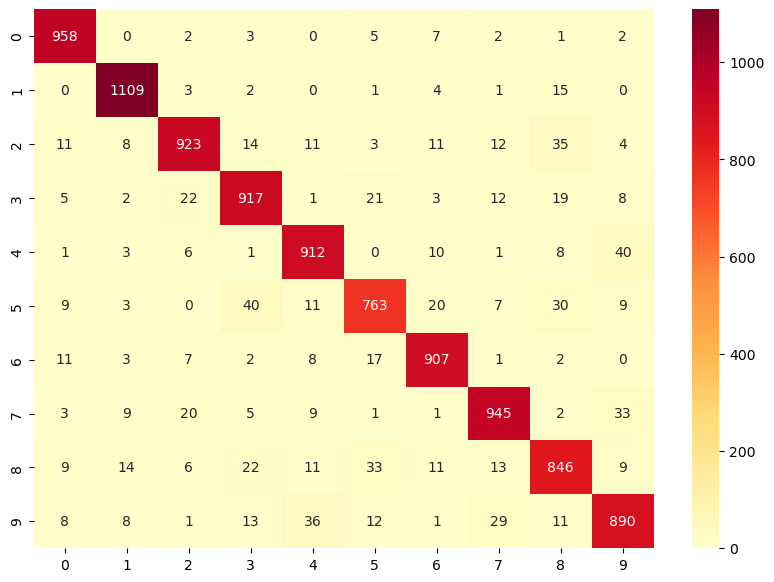

In [45]:
predicted = ovr_model2.predict(rX_test)
matrix = confusion_matrix(Y_test, predicted)

df_cm = pd.DataFrame(matrix)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlOrRd", fmt="d")

And we can rescale each column by the number of entries in that column (i.e. the number of elements of that class in the test dataset) so that each diagonal element is the True Positive Rate (or Recall) $TPR = TP/(TP + FN)$ for that class:

<Axes: >

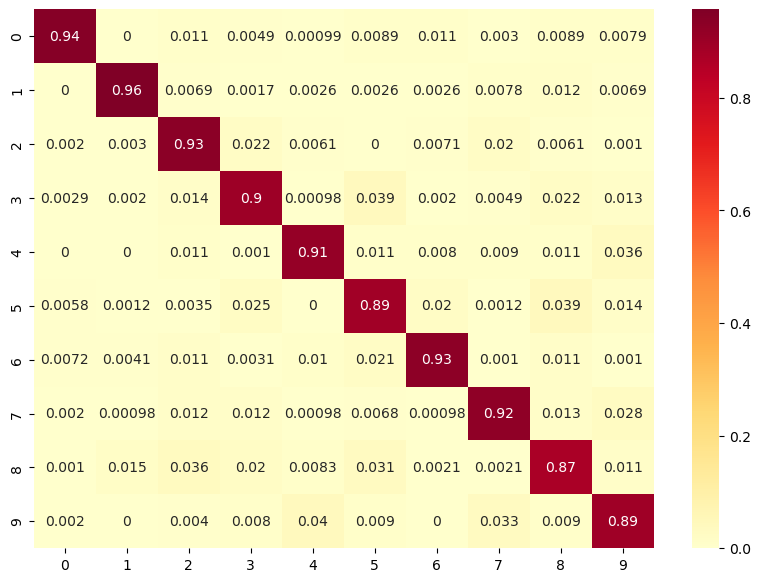

In [46]:
matrix_resc = np.array([matrix[:,j]/sum(matrix[:,j]) for j in range(10)])

df_cm = pd.DataFrame(matrix_resc)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlOrRd")

We notice that our model has problems classifying the '8's, which is the class with the worst recall.
We can also go one step further and subtract the diagonal from this matrix, which will allow us to see the dominant errors in our model's predictions:

<Axes: >

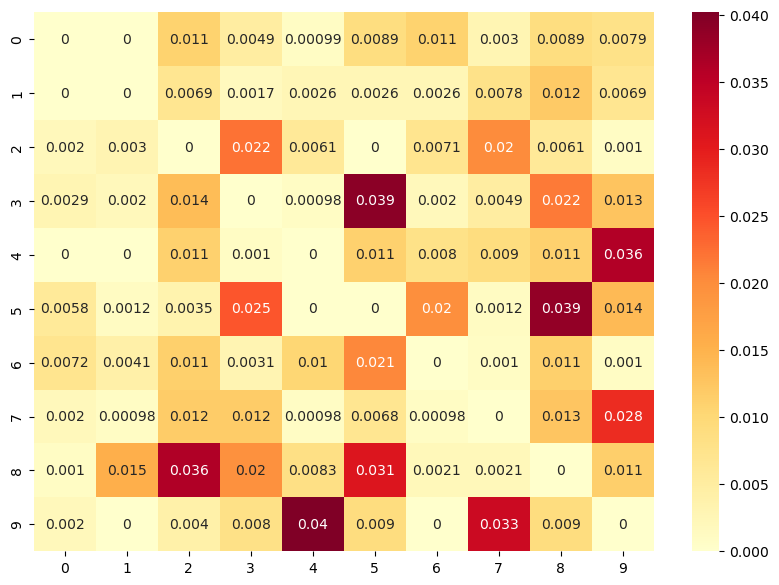

In [47]:
matrix_err = matrix_resc - np.diag([matrix_resc[i,i] for i in range(10)])

df_cm = pd.DataFrame(matrix_err)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlOrRd")

Then we see that 3% and 2% of the '8' are being classified as '5' and '3' respectively, which makes sense since they have similar shapes when handwritten. There are also fractions of '9's classified as '4's and viceversa, and some '2' classified as '8'.

We can repeat the procedure for the multinomial model:

<Axes: >

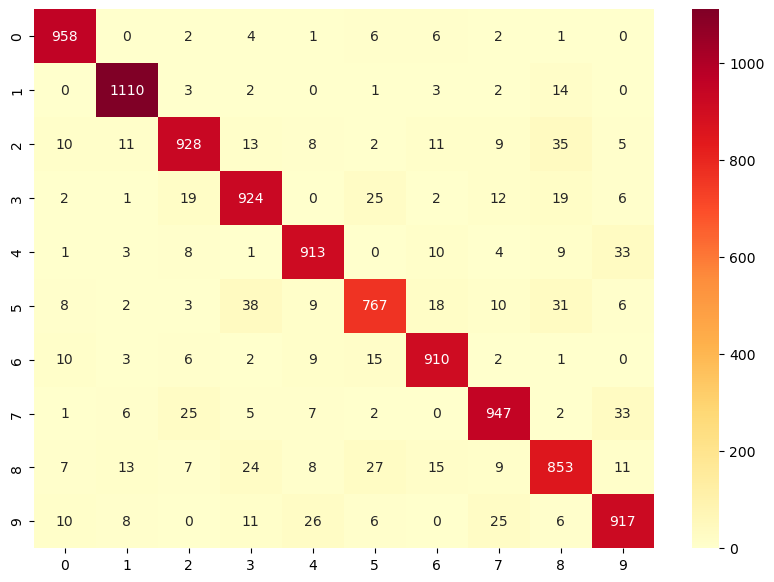

In [48]:
predicted = multmodel_bestC.predict(rX_test)
matrix_mult = confusion_matrix(Y_test, predicted)

df_cm = pd.DataFrame(matrix_mult)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlOrRd", fmt="d")

<Axes: >

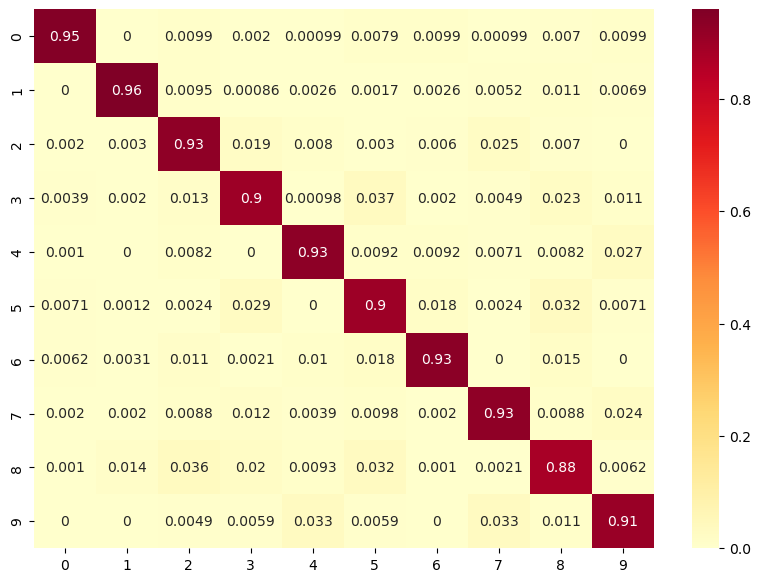

In [49]:
matrix_mult_resc = np.array([matrix_mult[:,j]/sum(matrix_mult[:,j]) for j in range(10)])

df_cm = pd.DataFrame(matrix_mult_resc)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlOrRd")

<Axes: >

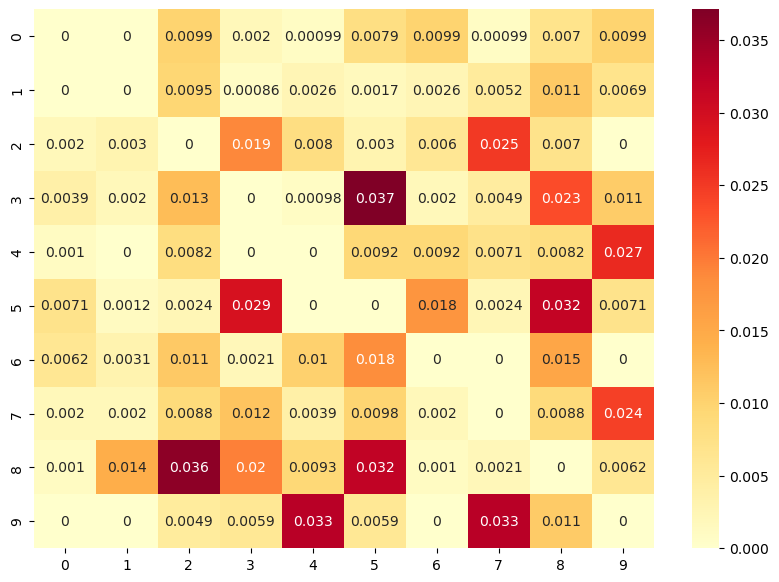

In [50]:
matrix_mult_err = matrix_mult_resc - np.diag([matrix_mult_resc[i,i] for i in range(10)])

df_cm = pd.DataFrame(matrix_mult_err)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlOrRd")

where we see that the model achieves similar predictions.

So far we considered the accuracy, that is, a metric that sums up the ability of the models to correctly classify the different digits for a given decision threshold, and that works well for balanced classes (which is the case in this dataset) and when the "cost" in a FP mistake is the same as a FN.

For the number recognition task, it ultimately depends on what it is being applied for, since it is a very general and multipurpose ability. Thus, as a complement, we can also consider the Receiver Operating Characteristic (ROC) metric applied to the multiclass case. In binary classification problems the ROC and the corresponding area under the curve (AUC) yield the probability that a randomly chosen positive example is ranked higher than a randomly chosen negative example. We can generalize this to a multiclass classification problem by adopting a One-vs-Rest evaluation scheme. Each AUC will then tell us how good is out model in assigning probabilities for a given class against all the others. The (micro)average over the classes will then give us the average behaviour of our model.

Concretely, for every class $n$ we compute the True Positive Rate against the False Positive Rate for all decision thresholds. Then the multiclass ROC curve will be obtained by computing

$$TPR = \frac{\sum_n TP_n}{\sum_n TP_n + FN_n}$$
$$FPR = \frac{\sum_n FP_n}{\sum_n FP_n + TN_n}$$

for all said thresholds.
For example, for the current decision threshold these two quantities are:

In [51]:
# helper function that reduces the full confusion matrix to a one-vs-rest confusion matrix for class n
def marginalize(matrix, n):
    new_matrix = np.zeros((2,2))
    new_matrix[0,0] = matrix[n,n] #TP
    new_matrix[0,1] = sum(matrix[n,j] for j in range(10) if j!=n) #FP
    new_matrix[1,0] = sum(matrix[j,n] for j in range(10) if j!=n) #FN
    new_matrix[1,1] = sum(matrix[j,k] for k in range(10) for j in range(10) if (j!=n and k!=n)) #TN
    return new_matrix

In [52]:
sumTP = sum(marginalize(matrix, n)[0,0] for n in range(10))
sumFN = sum(marginalize(matrix, n)[1,0] for n in range(10))
TPR = sumTP/(sumTP+sumFN)
print(TPR)

0.917


In [53]:
sumFP = sum(marginalize(matrix, n)[0,1] for n in range(10))
sumTN = sum(marginalize(matrix, n)[1,1] for n in range(10))
FPR = sumFP/(sumFP+sumTN)
print(FPR)

0.009222222222222222


The full curve can be computed with sklearn's `RocCurveDisplay` method.

In [54]:
# we need to turn the Y_test vector into a list of one-hot vectors, one for each class
Yn_test = np.array(multi_to_OH(Y_test))
Yn_test = np.swapaxes(Yn_test, 0, 1)

In [55]:
Yn_test.shape

(10000, 10)

In [56]:
# then we need predicted probabilities 
Y_ovr_proba = ovr_model2.predict_proba(rX_test)
Y_mult_proba = multmodel_bestC.predict_proba(rX_test)

In [57]:
Y_ovr_proba.shape

(10000, 10)

[Text(0.5, 0, 'FPR'),
 Text(0, 0.5, 'TPR'),
 Text(0.5, 1.0, 'Micro-averaged One-vs-Rest\nReceiver Operating Characteristic')]

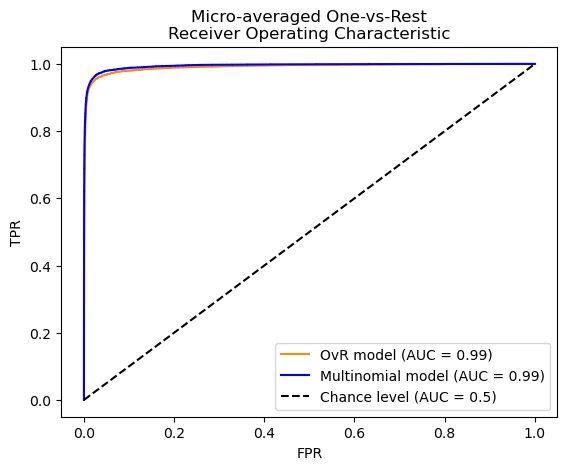

In [58]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(
    Yn_test.ravel(),
    Y_ovr_proba.ravel(),
    name="OvR model",
    color="darkorange",
    ax=ax,
)

RocCurveDisplay.from_predictions(
    Yn_test.ravel(),
    Y_mult_proba.ravel(),
    name="Multinomial model",
    color="blue",
    ax=ax,
    plot_chance_level=True,
)


ax.set(
    xlabel="FPR",
    ylabel="TPR",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

Where we see that both models achieve an AUC of 0.99.